In [1]:
import bempp.api
import numpy as np

bempp.api.global_parameters.assembly.boundary_operator_assembly_type = 'dense'

In [2]:
hvec = np.linspace(0.1, 0.5, 20)

k_ext = 1.5
k_int = 2
mu_int = 1
mu_ext = 1

In [3]:
e_error = []
m_error = []

In [4]:
def plane_wave_e(x, n, d, res):
    val =  np.array([np.exp(1j * k_ext * x[2]), 0, 0])
    res[:] = np.cross(val, n)
    
def plane_wave_m(x, n, d, res):
    val = np.array([0, 1., 0]) * np.exp(1j * k_ext * x[2])
    res[:] = np.cross(val, n)

## Testing with the BC spaces with the discretization as described in http://www.sciencedirect.com/science/article/pii/S0898122117304789?via%3Dihub

In [5]:
for h in hvec:
    grid = bempp.api.shapes.cube(h=h)
    multitrace = bempp.api.operators.boundary.maxwell.multitrace_operator(grid, k_int)
    identity = bempp.api.operators.boundary.sparse.multitrace_identity(grid, spaces='maxwell')
    
    
    scaling_interior_1 = bempp.api.operators.boundary.sparse.multitrace_identity(grid, spaces = "maxwell")
    scaling_interior_2 = bempp.api.operators.boundary.sparse.multitrace_identity(grid, spaces = "maxwell")

    scaling_interior_1[1,1] = (k_int / mu_int) * scaling_interior_1[1,1]
    scaling_interior_2[1,1] = (mu_int / k_int) * scaling_interior_2[1,1]
    
    multitrace_scaled = scaling_interior_1 * multitrace * scaling_interior_2
    
    calderon = 0.5 * identity + multitrace_scaled
    
    electric_trace = bempp.api.GridFunction(space=calderon.domain_spaces[0], fun=plane_wave_e, 
                                        dual_space=calderon.dual_to_range_spaces[0])

    magnetic_trace = (k_ext/mu_ext) * bempp.api.GridFunction(space=calderon.domain_spaces[1], fun=plane_wave_m,
                                        dual_space=calderon.dual_to_range_spaces[1])
    
    
    traces_1 = calderon * [electric_trace, magnetic_trace]
    traces_2 = calderon * traces_1
    
    electric_error = (traces_2[0] - traces_1[0]).l2_norm() / traces_1[0].l2_norm()
    magnetic_error = (traces_2[1] - traces_1[1]).l2_norm() / traces_1[1].l2_norm()
    
    e_error.append(electric_error)
    m_error.append(magnetic_error)
    
    print('Mesh size: {0}'.format(h))
    print("Electric error is ", electric_error)
    print("Magnetic error is ", magnetic_error)
    

Mesh size: 0.08
Electric error is  0.00307880706806
Magnetic error is  0.00166962302639
Mesh size: 0.08857142857142858
Electric error is  0.00298210001828
Magnetic error is  0.00161858248843
Mesh size: 0.09714285714285714
Electric error is  0.00332192362141
Magnetic error is  0.00166083149388
Mesh size: 0.10571428571428572
Electric error is  0.00330807697996
Magnetic error is  0.00176123662838
Mesh size: 0.1142857142857143
Electric error is  0.00338901781363
Magnetic error is  0.00192981233721
Mesh size: 0.12285714285714286
Electric error is  0.0033904959932
Magnetic error is  0.00192959802451
Mesh size: 0.13142857142857145
Electric error is  0.00417509477585
Magnetic error is  0.00210311094188
Mesh size: 0.14
Electric error is  0.00424144235401
Magnetic error is  0.00207224869082
Mesh size: 0.14857142857142858
Electric error is  0.00395850784743
Magnetic error is  0.00194652598528
Mesh size: 0.15714285714285714
Electric error is  0.00392561948029
Magnetic error is  0.00195563872977
Me

In [6]:
slope_e, intercept_e = np.polyfit(np.log(hvec), np.log(e_error), 1)
slope_m, intercept_m = np.polyfit(np.log(hvec), np.log(m_error), 1)

print("Order of electric error: {0}".format(slope_e))
print("Order of magnetic error: {0}".format(slope_m))

Order of electric error: 0.43013251208423814
Order of magnetic error: 0.41536733696619843


In [7]:
y_e = intercept_e + slope_e * np.log(hvec)
y_m = intercept_m + slope_m * np.log(hvec)

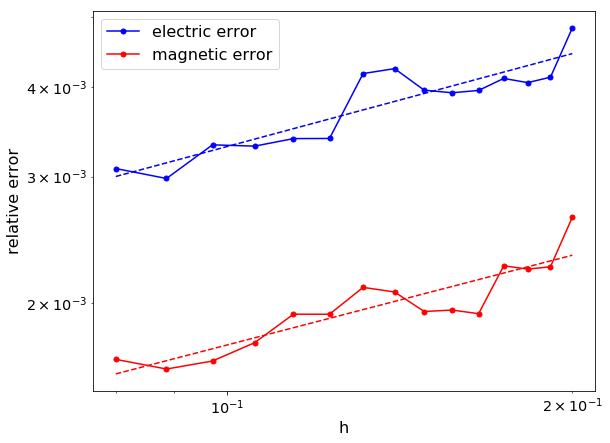

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.figure(figsize=(9,7))
plt.loglog(hvec, e_error, 'b.-', markersize=10)
plt.loglog(hvec, m_error, 'r.-', markersize=10)
plt.loglog(hvec, np.exp(y_e), 'b--', markersize = 10)
plt.loglog(hvec, np.exp(y_m), 'r--', markersize = 10)
plt.legend(["electric error", "magnetic error"],fontsize = 16)

plt.xlabel('h', fontsize = 16)
plt.ylabel('relative error', fontsize = 16)
plt.show()



## Testing with CW basis functions on the barycentric grid

In [5]:
e_error = []
m_error = []

In [5]:
for h in hvec:
    grid = bempp.api.shapes.cube(h=h)
    multitrace = bempp.api.assembly.BlockedOperator(2, 2)
    identity = bempp.api.assembly.BlockedOperator(2, 2)
    
    rwg_space_fine = bempp.api.function_space(grid.barycentric_grid(), "RWG", 0)
    rwg_space = bempp.api.function_space(grid, "B-RWG", 0)
    cw_space = bempp.api.function_space(grid, "CW", 0)
    rcw_space = bempp.api.function_space(grid, "RCW", 0)
    snc_space = bempp.api.function_space(grid, "B-SNC", 0)
    snc_space_fine = bempp.api.function_space(grid.barycentric_grid(), "SNC", 0)
    
    efie_fine = bempp.api.operators.boundary.maxwell.electric_field(rwg_space_fine, rwg_space_fine,
                                                                      snc_space_fine, k_int)
    mfie_fine = bempp.api.operators.boundary.maxwell.magnetic_field(rwg_space_fine, rwg_space_fine, 
                                                                      snc_space_fine, k_int)
    
    multitrace[0, 0] = bempp.api.space.project_operator(mfie_fine, rwg_space, rwg_space, rcw_space)
    multitrace[0, 1] = (mu_int / k_int) * bempp.api.space.project_operator(efie_fine, cw_space, rwg_space, rcw_space)
    multitrace[1, 0] = -(k_int / mu_int) * bempp.api.space.project_operator(efie_fine, rwg_space, cw_space, snc_space)
    multitrace[1, 1] = bempp.api.space.project_operator(mfie_fine, cw_space, cw_space, snc_space)

    identity[0, 0] = bempp.api.operators.boundary.sparse.identity(rwg_space, rwg_space, rcw_space)
    identity[1, 1] = bempp.api.operators.boundary.sparse.identity(cw_space, cw_space, snc_space)
    
    calderon = 0.5 * identity + multitrace
    
    electric_trace = bempp.api.GridFunction(space=calderon.domain_spaces[0], fun=plane_wave_e, 
                                        dual_space=calderon.dual_to_range_spaces[0])

    magnetic_trace = (k_ext/mu_ext) * bempp.api.GridFunction(space=calderon.domain_spaces[1], fun=plane_wave_m,
                                        dual_space=calderon.dual_to_range_spaces[1])
    
    
    traces_1 = calderon * [electric_trace, magnetic_trace]
    traces_2 = calderon * traces_1
    
    electric_error = (traces_2[0] - traces_1[0]).l2_norm() / traces_1[0].l2_norm()
    magnetic_error = (traces_2[1] - traces_1[1]).l2_norm() / traces_1[1].l2_norm()
    
    e_error.append(electric_error)
    m_error.append(magnetic_error)
    
    print('Mesh size: {0}'.format(h))
    print("Electric error is ", electric_error)
    print("Magnetic error is ", magnetic_error)
    

Mesh size: 0.1
Electric error is  0.627919286367
Magnetic error is  536.852597924
Mesh size: 0.12105263157894737
Electric error is  0.643986565546
Magnetic error is  421.009180531
Mesh size: 0.14210526315789473
Electric error is  0.63406529837
Magnetic error is  411.819911136
Mesh size: 0.1631578947368421
Electric error is  0.66039123935
Magnetic error is  271.028020312
Mesh size: 0.1842105263157895
Electric error is  0.655698053404
Magnetic error is  230.918787566
Mesh size: 0.20526315789473684
Electric error is  0.688067759011
Magnetic error is  173.941630197
Mesh size: 0.22631578947368422
Electric error is  0.692786472975
Magnetic error is  171.185228922
Mesh size: 0.24736842105263157
Electric error is  0.685339363809
Magnetic error is  172.701050138
Mesh size: 0.26842105263157895
Electric error is  0.646271866324
Magnetic error is  126.225898986
Mesh size: 0.2894736842105263
Electric error is  0.646271866324
Magnetic error is  126.225898986
Mesh size: 0.31052631578947365
Electric e

In [6]:
slope_e, intercept_e = np.polyfit(np.log(hvec), np.log(e_error), 1)
slope_m, intercept_m = np.polyfit(np.log(hvec), np.log(m_error), 1)

print("Order of electric error: {0}".format(slope_e))
print("Order of magnetic error: {0}".format(slope_m))

Order of electric error: 0.1731455823596192
Order of magnetic error: -1.202487866654394


In [7]:
y_e = intercept_e + slope_e * np.log(hvec)
y_m = intercept_m + slope_m * np.log(hvec)

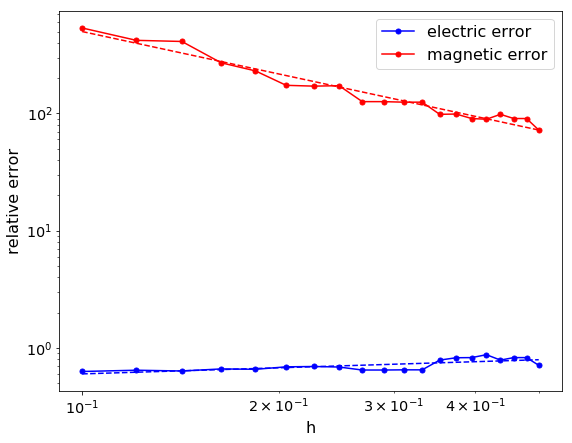

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.figure(figsize=(9,7))
plt.loglog(hvec, e_error, 'b.-', markersize=10)
plt.loglog(hvec, m_error, 'r.-', markersize=10)
plt.loglog(hvec, np.exp(y_e), 'b--', markersize = 10)
plt.loglog(hvec, np.exp(y_m), 'r--', markersize = 10)
plt.legend(["electric error", "magnetic error"],fontsize = 16)

plt.xlabel('h', fontsize = 16)
plt.ylabel('relative error', fontsize = 16)
plt.show()




## Testing with CW coefficients on the Bogaert grid

In [9]:
e_error = []
m_error = []

In [10]:
for h in hvec:
    grid = bempp.api.shapes.cube(h=h)
    multitrace = bempp.api.assembly.BlockedOperator(2, 2)
    identity = bempp.api.assembly.BlockedOperator(2, 2)
    
    rwg_space_fine = bempp.api.function_space(grid.bogaert_refinement_grid(), "RWG", 0)
    rwg_space = bempp.api.function_space(grid, "BG-RWG", 0)
    mcw_space = bempp.api.function_space(grid, "MCW", 0)
    mrcw_space = bempp.api.function_space(grid, "MRCW", 0)
    snc_space = bempp.api.function_space(grid, "BG-SNC", 0)
    snc_space_fine = bempp.api.function_space(grid.bogaert_refinement_grid(), "SNC", 0)
    
    efie_fine = bempp.api.operators.boundary.maxwell.electric_field(rwg_space_fine, rwg_space_fine,
                                                                      snc_space_fine, k_int)
    mfie_fine = bempp.api.operators.boundary.maxwell.magnetic_field(rwg_space_fine, rwg_space_fine, 
                                                                      snc_space_fine, k_int)
    
    multitrace[0, 0] = bempp.api.space.project_operator(mfie_fine, rwg_space, rwg_space, mrcw_space)
    multitrace[0, 1] = (mu_int / k_int) * bempp.api.space.project_operator(efie_fine, mcw_space, rwg_space, mrcw_space)
    multitrace[1, 0] = -(k_int / mu_int) * bempp.api.space.project_operator(efie_fine, rwg_space, mcw_space, snc_space)
    multitrace[1, 1] = bempp.api.space.project_operator(mfie_fine, mcw_space, mcw_space, snc_space)

    identity[0, 0] = bempp.api.operators.boundary.sparse.identity(multitrace.domain_spaces[0],
                                                                  multitrace.range_spaces[0],
                                                                  multitrace.dual_to_range_spaces[0])
    identity[1, 1] = bempp.api.operators.boundary.sparse.identity(multitrace.domain_spaces[1], 
                                                                  multitrace.range_spaces[1],
                                                                  multitrace.dual_to_range_spaces[1])
    calderon = 0.5 * identity + multitrace
    
    electric_trace = bempp.api.GridFunction(space=calderon.domain_spaces[0], fun=plane_wave_e, 
                                        dual_space=calderon.dual_to_range_spaces[0])

    magnetic_trace = (k_ext/mu_ext) * bempp.api.GridFunction(space=calderon.domain_spaces[1], fun=plane_wave_m,
                                        dual_space=calderon.dual_to_range_spaces[1])
    
    
    traces_1 = calderon * [electric_trace, magnetic_trace]
    traces_2 = calderon * traces_1
    
    electric_error = (traces_2[0] - traces_1[0]).l2_norm() / traces_1[0].l2_norm()
    magnetic_error = (traces_2[1] - traces_1[1]).l2_norm() / traces_1[1].l2_norm()
    
    e_error.append(electric_error)
    m_error.append(magnetic_error)
    
    print('Mesh size: {0}'.format(h))
    print("Electric error is ", electric_error)
    print("Magnetic error is ", magnetic_error)
    

Mesh size: 0.1
Electric error is  0.656323389853
Magnetic error is  524.26346038
Mesh size: 0.12105263157894737
Electric error is  0.659887898815
Magnetic error is  413.422035765
Mesh size: 0.14210526315789473
Electric error is  0.69352238793
Magnetic error is  399.885345773
Mesh size: 0.1631578947368421
Electric error is  0.669230163878
Magnetic error is  262.200588706
Mesh size: 0.1842105263157895
Electric error is  0.689857813335
Magnetic error is  226.544508518
Mesh size: 0.20526315789473684
Electric error is  0.736338077685
Magnetic error is  166.450219996
Mesh size: 0.22631578947368422
Electric error is  0.749722385688
Magnetic error is  164.628692977
Mesh size: 0.24736842105263157
Electric error is  0.738191866778
Magnetic error is  167.115182833
Mesh size: 0.26842105263157895
Electric error is  0.627862777305
Magnetic error is  123.919762521
Mesh size: 0.2894736842105263
Electric error is  0.627862777305
Magnetic error is  123.919762521
Mesh size: 0.31052631578947365
Electric e

In [11]:
slope_e, intercept_e = np.polyfit(np.log(hvec), np.log(e_error), 1)
slope_m, intercept_m = np.polyfit(np.log(hvec), np.log(m_error), 1)

print("Order of electric error: {0}".format(slope_e))
print("Order of magnetic error: {0}".format(slope_m))

Order of electric error: 0.15570423270155495
Order of magnetic error: -1.2231450598082207


In [12]:
y_e = intercept_e + slope_e * np.log(hvec)
y_m = intercept_m + slope_m * np.log(hvec)

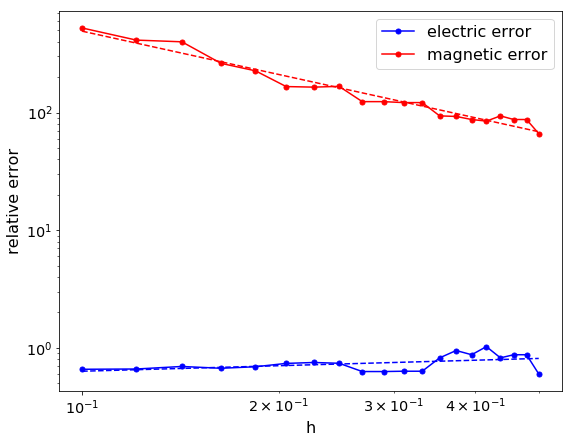

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.figure(figsize=(9,7))
plt.loglog(hvec, e_error, 'b.-', markersize=10)
plt.loglog(hvec, m_error, 'r.-', markersize=10)
plt.loglog(hvec, np.exp(y_e), 'b--', markersize = 10)
plt.loglog(hvec, np.exp(y_m), 'r--', markersize = 10)
plt.legend(["electric error", "magnetic error"],fontsize = 16)

plt.xlabel('h', fontsize = 16)
plt.ylabel('relative error', fontsize = 16)
plt.show()

In [14]:
h = 0.5

In [15]:
grid = bempp.api.shapes.cube(h=h)
multitrace = bempp.api.assembly.BlockedOperator(2, 2)
identity = bempp.api.assembly.BlockedOperator(2, 2)
    
rwg_space_fine = bempp.api.function_space(grid.bogaert_refinement_grid(), "RWG", 0)
rwg_space = bempp.api.function_space(grid, "BG-RWG", 0)
cw_space = bempp.api.function_space(grid, "MCW", 0)
rcw_space = bempp.api.function_space(grid, "MRCW", 0)
snc_space = bempp.api.function_space(grid, "BG-SNC", 0)
snc_space_fine = bempp.api.function_space(grid.bogaert_refinement_grid(), "SNC", 0)
    
efie_fine = bempp.api.operators.boundary.maxwell.electric_field(rwg_space_fine, rwg_space_fine,
                                                                      snc_space_fine, k_int)
mfie_fine = bempp.api.operators.boundary.maxwell.magnetic_field(rwg_space_fine, rwg_space_fine, 
                                                                      snc_space_fine, k_int)
    
multitrace[0, 0] = bempp.api.space.project_operator(mfie_fine, rwg_space, rwg_space, rcw_space)
multitrace[0, 1] = (mu_int / k_int) * bempp.api.space.project_operator(efie_fine, cw_space, rwg_space, rcw_space)
multitrace[1, 0] = -(k_int / mu_int) * bempp.api.space.project_operator(efie_fine, rwg_space, cw_space, snc_space)
multitrace[1, 1] = bempp.api.space.project_operator(mfie_fine, cw_space, cw_space, snc_space)



In [16]:
multitrace.dual_to_range_spaces

(<bempp.api.space.space.ModifiedRotatedChenWiltonSpace at 0x7f516e71eb38>,
 <bempp.api.space.space.BogaertSNCSpace at 0x7f51a39e1860>)

In [17]:
identity[0, 0] = bempp.api.operators.boundary.sparse.identity(multitrace.domain_spaces[0], multitrace.range_spaces[0],
                                                              multitrace.dual_to_range_spaces[0])
identity[1, 1] = bempp.api.operators.boundary.sparse.identity(multitrace.domain_spaces[1], multitrace.range_spaces[1],
                                                              multitrace.dual_to_range_spaces[1])
    
calderon = 0.5 * identity + multitrace
    
electric_trace = bempp.api.GridFunction(space=calderon.domain_spaces[0], fun=plane_wave_e, 
                                        dual_space=calderon.dual_to_range_spaces[0])

magnetic_trace = (k_ext/mu_ext) * bempp.api.GridFunction(space=calderon.domain_spaces[1], fun=plane_wave_m,
                                        dual_space=calderon.dual_to_range_spaces[1])
    
    
traces_1 = calderon * [electric_trace, magnetic_trace]
traces_2 = calderon * traces_1
    
electric_error = (traces_2[0] - traces_1[0]).l2_norm() / traces_1[0].l2_norm()
magnetic_error = (traces_2[1] - traces_1[1]).l2_norm() / traces_1[1].l2_norm()
    
e_error.append(electric_error)
m_error.append(magnetic_error)
    
print('Mesh size: {0}'.format(h))
print("Electric error is ", electric_error)
print("Magnetic error is ", magnetic_error)

Mesh size: 0.5
Electric error is  0.599487673361
Magnetic error is  66.2826113947


In [65]:
multitrace.domain_spaces

(<bempp.api.space.space.BogaertRWGSpace at 0x7ff6b4106ac8>,
 <bempp.api.space.space.ModifiedChenWiltonSpace at 0x7ff6b40def60>)

In [35]:
magnetic_trace.dual_space

In [79]:
h = 10/(2*np.pi*k_ext)

In [80]:
h

1.0610329539459689